In [2]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00


In [4]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

from catboost import CatBoostClassifier
from catboost import Pool, cv

sns.set()

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### About dataset
The dataset contains credit card transactions made in September 2013 by European cardholders. This dataset contains transactions made in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, with a positive class (fraudsters) representing 0.172% of all transactions.
It contains only numerical input variables, which are the result of a PCA (Principal Component Analysis) transformation. Unfortunately, for privacy reasons, we cannot provide the original traits and more detailed information about the data. The signs V1, V2, ... V28 are principal components obtained by PCA, the only features that were not transformed by PCA are Time and Amount.

The Time attribute contains the seconds elapsed between each transaction and the first transaction in the dataset.
The Amount attribute is the amount of the transaction, this attribute can be used for cost-aware training depending on the example.
The Class attribute is a response variable and takes the value 1 in case of fraud and 0 otherwise.

## Process the data

In [15]:
df= pd.read_csv('/content/drive/MyDrive/ML_2/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [16]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [24]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [29]:
# There are no data omissions
nan = df.isna().sum().sum()
print(f'Number of values NaN: {nan}')

Number of values NaN: 0


Taking into account that the meaning of the overwhelming part of the data is unknown, we will pay special attention to the time and Amount columns

So We can assume that the time column in this format will not correlate with the class label.

In [30]:
# Remove duplicates from the data
len_df = len(df)
df.drop_duplicates(inplace=True)
duplicates = len_df - len(df)
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 0


In [26]:
# The classes are highly unbalanced
percent = round(df.Class.value_counts()[1] / df.shape[0] * 100, 3)
print(f'Percentage of fraudulent transactions: {percent}')

Percentage of fraudulent transactions: 0.167


All columns have a strong scatter of values, normalization will be required for linear models to work adequately.

In [27]:
# Basic trait statistics:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


It can be seen that columns V1-V29 are not correlated with each other. This can be immediately determined from the fact that these attributes are obtained using principal component analysis. It is also worth noting that the time and amount columns are not correlated with the target variable class, it may be worth converting them to a different form.

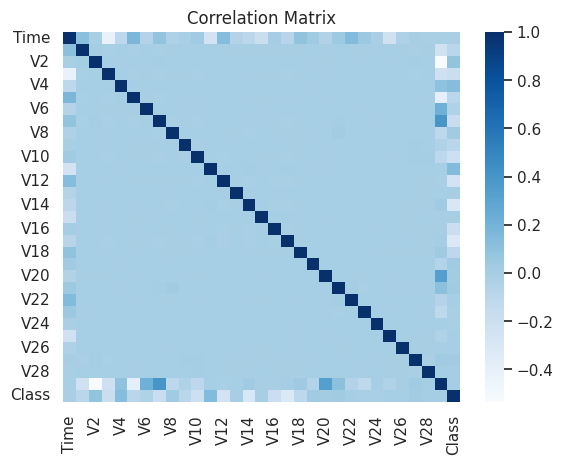

In [31]:
# Check the correlation matrix if there are no highly correlated parameters
sns.heatmap(df.corr(), cbar=True, cmap="Blues")
plt.title("Correlation Matrix")
plt.show()

In this problem there is a strong class imbalance. To evaluate the quality of the model we will use the Recall metric

In [19]:
df['Class'].value_counts()

0    283253
1       473
Name: Class, dtype: int64

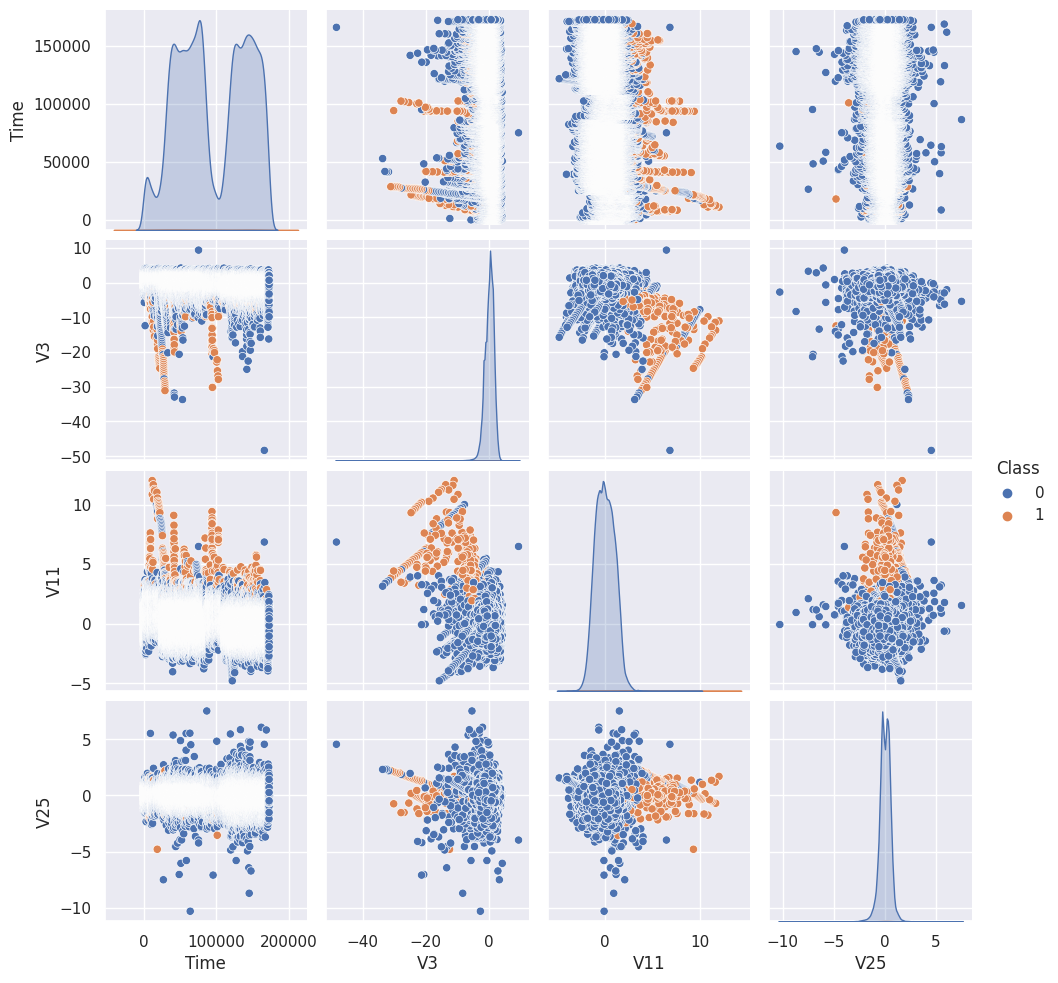

In [32]:
# Build a pairplot for a part of parameters, we choose random 4 parameters
# Judging by the images, the data are separated nonlinearly, but nevertheless, it is possible to separate them
selected_features = ['Time', 'V3', 'V11', 'V25']
data_subset = df[selected_features + ['Class']]
sns.pairplot(data_subset, hue='Class', diag_kind='kde')
plt.show()

## LogisticRegression

Due to the large amount of data, to begin with, we will try to solve the problem by logistic regression, the choice is also due to the fact that it can work with unbalanced classes 'out of the box'

In [33]:
# Logistic regression is one of the basic machine learning algorithms and can be effective for classifying unbalanced data, so we will use it first
X = df.drop(['Class'], axis = 1)
y = df.Class

In [34]:
# Divide the data into training and test parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

percent_train = round(y_train.value_counts()[1] / y_train.shape[0] * 100, 3)
percent_test = round(y_test.value_counts()[1] / y_test.shape[0] * 100, 3)
print(f'Percentage of fraudulent transactions: {percent_train}')
print(f'Percentage of fraudulent transactions: {percent_test}')

Percentage of fraudulent transactions: 0.167
Percentage of fraudulent transactions: 0.167


In [35]:
# Compare the statistics of the training and test samples
X_train.describe() - X_test.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,...,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000
mean,349.321162,-0.002689,-0.000255,0.002039,0.010443,0.010629,0.002622,-0.000741,0.002758,-0.006590,...,0.001912,0.003912,-0.000073,-0.001938,0.001932,-0.001253,0.000507,-0.000846,0.003402,-0.503359
std,15.555743,-0.002333,-0.001586,-0.008102,0.017189,-0.064794,-0.023878,-0.094303,-0.016544,-0.002261,...,-0.049513,0.009040,0.000473,-0.012400,-0.002718,-0.001623,-0.003465,-0.015500,0.005570,-25.075175
min,-1.000000,-18.849443,-9.371029,14.644605,-0.123054,81.651178,-4.231194,-10.317913,-22.528299,-2.591540,...,30.850830,-11.941035,1.433721,11.978740,0.011778,1.598770,-0.070221,-12.670435,3.719188,0.000000
25%,238.500000,0.000747,0.003226,0.007934,0.002752,0.004931,0.003387,0.000541,0.000074,-0.001479,...,0.000850,-0.000129,0.002692,-0.000655,0.001579,-0.002673,0.001735,0.000533,0.001122,0.210000
50%,352.000000,-0.011077,0.002021,-0.007644,0.001674,0.005545,-0.002510,0.001078,0.001109,-0.001981,...,0.000647,0.001309,-0.000184,-0.001124,0.000439,-0.001868,0.001958,-0.000102,0.000847,0.180000
75%,272.750000,-0.003153,0.006808,-0.000498,0.013695,0.005580,0.004482,0.006003,0.000725,-0.005851,...,0.000617,0.000876,0.001640,0.000833,0.001836,-0.000798,-0.002883,0.001037,0.001940,0.700000
max,6.000000,0.015723,4.639080,5.280842,0.159807,1.890204,-51.908557,-86.286317,-0.419436,5.202106,...,-1.303695,7.139053,2.230857,0.444867,-0.568207,1.448738,0.054100,-19.459797,17.981087,-6781.160000


In [36]:
# Normalize the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

In [37]:
# Creat and traina logistic regression model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_normalized, y_train);

In [38]:
# Prediction on a test sample
y_pred = model.predict(X_test_normalized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.89      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.93      0.54     85118
weighted avg       1.00      0.97      0.99     85118



The recall metric has quite large values, but the precision metric for Class = 1 has a value of only 0.05, which means that our model was able to select only 5% of the values from all those belonging to Class 1

To improve this metric we will try to use the 'random forest' model, since my work with the data to improve the metrics of the Logistic Regression model did not lead to significant results

## RandomForestClassifier

In [39]:
# Random Forest does a better job of finding complex dependencies in the data, so we further train the model on RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [40]:
X = df.drop(['Class'], axis = 1)
y = df.Class

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
scaler = StandardScaler()

In [43]:
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

In [44]:
# To reduce the training time, we use the parameter 'n_jobs' = -1, which uses all cores for the calculation
model = RandomForestClassifier(random_state=42, n_jobs=-1)
model.fit(X_train_normalized, y_train);

In [45]:
y_pred = model.predict(X_test_normalized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.77      0.86       142

    accuracy                           1.00     85118
   macro avg       0.98      0.89      0.93     85118
weighted avg       1.00      1.00      1.00     85118



The recall metric decreased from 0.89 to 0.77, but precision increased significantly more and is now 0.96

## Conclusion

With this work, we trained two models for credit card fraud detection; LogisticRegression and RandomForestClassifier. and analyzed the models based on two metrics: precision and recall.

Logistic Regression has precision and recall metrics of 0.05 and 0.89 respectively.And Random Forests have precision and recall metrics of 0.96 and 0.77 respectively.

Using the logistic regression model, we will be less likely to classify normal transactions as fraudulent, but the number of fraudulent transactions detected will be very small compared to all similar transactions.

Therefore, the random tree model performed better in this case. Although it made more false positive choices (false positive), it also made many more true positive choices (true positive).